Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Hung-Wei Chang"
COLLABORATORS = ""

---

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Assignment 4
We are going to do some analysis on flight delays using a data source from the US Bureau of Transportation Statistics (https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236), which provides historical data for every commercial flight in the U.S. since 1987.  In this exercise we will work  small subset of this data for all flights in the U.S. during the month of August 2019.  

Let's suppose we would like to build a model to be able to predict expected delay on a flight at any given point in the future.  We might consider using factors such as the following in our predictive model:  
- Origin airport (certain airports may have more delays on average) 
- Airline (certain airlines might have higher delays) 
- Time of day, day of week  
- Season of year and/or month
- Forecasted weather conditions  
- Etc.

Think for a moment about whether you would expect each of the above factors to influence expected delay, and if so, why?  

In this exercise we will explore a couple of those factors to see if they influence the amount of delay we would expect, given the historical data we have available.

Before you go any further please run the following code cell to download the data you need to your laptop.  After doing so, please ensure that you are able to locate the csv files in the same folder as this notebook.

In [3]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Aug2019_flights.csv':'https://storage.googleapis.com/aipi_datasets/Aug2019_flights.csv',
        'Airport_codes.csv': 'https://storage.googleapis.com/aipi_datasets/Airport_codes.csv',
        'Airline_codes.csv': 'https://storage.googleapis.com/aipi_datasets/Airline_codes.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

### Question 0 [10 pts]
Before we dive into any analysis, let's load our data, see how much we have, and take a look at the structure.  We have our main data file 'Aug2019_flights.csv' and we also have a separate mapper file 'Airport_codes.csv' which we will later use to map numerical airport codes to the airport names.  

Complete the below function `load_data()` which loads the two files, converts them both to dataframes, and then returns the two dataframes.

In [4]:
def load_data(data_filename, mapper_filename):
    # YOUR CODE HERE
    df_filename = pd.read_csv(data_filename)
    df_mapper = pd.read_csv(mapper_filename)
    
    return (df_filename, df_mapper)
    raise NotImplementedError()

In [5]:
# Read in the data and display the head to see what data we have
flight_data, airport_map = load_data("Aug2019_flights.csv","Airport_codes.csv")
print('During the month of August 2019 there were {} flights'.format(len(flight_data)))
display(flight_data.head())
print('Mapper file:')
display(airport_map.head())

# Hidden tests below
assert flight_data.shape==(658461, 10)
assert airport_map.shape==(6545, 2)

During the month of August 2019 there were 658461 flights


,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,WEATHER_DELAY
0,1,8/12/19,9E,5001,10397,10781,1050,0.0,0,NaN
1,1,8/19/19,9E,5001,10397,10781,1050,0.0,0,NaN
2,1,8/26/19,9E,5001,10397,10781,1050,0.0,0,NaN
3,1,8/5/19,9E,5001,10781,10397,1159,74.0,0,0.0
4,1,8/12/19,9E,5001,10781,10397,1159,0.0,0,NaN


Mapper file:


,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


We can see above that our data contains several pieces of information about each flight:  
    - DAY_OF_WEEK: Day of week (1-7)  
    - FL_DATE: Flight date  
    - OP_UNIQUE_CARRIER: Airline (represented using an airline code)  
    - OP_CARRIER_FL_NUM: Flight number  
    - ORIGIN_AIRPORT_ID: ID number of origin airport 
    - DEST_AIRPORT_ID: ID number of destination airport  
    - CRS_DEP_TIME: departure time  
    - DEP_DELAY_NEW: minutes of departure delay  
    - CANCELLED: 0 if not cancelled, 1 if cancelled  
    - WEATHER DELAY: minutes of weather delay
 

### Question 1 [30 pts]
Before we do any analysis on our data, the first thing we want to do is clean it up by adding the origin airport name using our mapping file.

Let's write a function `add_origin_airports(flight_data, mapper_file)` which takes as input a dataframe of flight data ('flight_data') and a dataframe of the same form as `airport_map` which maps airport codes to airport names ('mapper_file').  The function should do the following to the input dataframe:  
- Add a new column 'ORIGIN_AIRPORT' which contains the name of the origin airport from the mapper_file. You should do this by merging the data from the mapper_file into the input dataframe using a 'left' merge. Hint: you may have to rename the column after the merge.
- Add a new column 'ORIGIN_CITY' which lists the city location of the origin airport.  This can be obtained by splitting the city name out of the 'ORIGIN_AIRPORT' column.  For example, for the airport 'Atlanta, GA: Hartsfield-Jackson Atlanta International' the ORIGIN_CITY entry should be 'Atlanta, GA'.

The function should return a dataframe which contains all the columns of 'flight_data' in their original format and adds two new columns: 'ORIGIN_AIRPORT' and 'ORIGIN_CITY' as described above.  Be sure that your function does not perform any operations (e.g. any sorting or filtering) other than what is noted above.  

In [6]:
def add_origin_airports(flight_data, mapper_file):
    # YOUR CODE HERE
    flight_merge = flight_data.merge(mapper_file, left_on='ORIGIN_AIRPORT_ID', right_on='Code', how="left")
    flight_merge.rename(columns={'Description':'ORIGIN_AIRPORT'},inplace=True)
    flight_merge['ORIGIN_CITY']=flight_merge["ORIGIN_AIRPORT"].apply(lambda x: x.split(':')[0])  
    return flight_merge
    raise NotImplementedError()

In [7]:
# 'add_origin_airports()' test cell - contains hidden tests which are run during grading
new_df = add_origin_airports(flight_data,airport_map)
display(new_df.head())


,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,WEATHER_DELAY,Code,ORIGIN_AIRPORT,ORIGIN_CITY
0,1,8/12/19,9E,5001,10397,10781,1050,0.0,0,NaN,10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...","Atlanta, GA"
1,1,8/19/19,9E,5001,10397,10781,1050,0.0,0,NaN,10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...","Atlanta, GA"
2,1,8/26/19,9E,5001,10397,10781,1050,0.0,0,NaN,10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...","Atlanta, GA"
3,1,8/5/19,9E,5001,10781,10397,1159,74.0,0,0.0,10781,"Baton Rouge, LA: Baton Rouge Metropolitan/Ryan...","Baton Rouge, LA"
4,1,8/12/19,9E,5001,10781,10397,1159,0.0,0,NaN,10781,"Baton Rouge, LA: Baton Rouge Metropolitan/Ryan...","Baton Rouge, LA"


### Question 2 [30 pts]
Let's start by looking at how much the average delay varies based on the origin airport of a flight.  It might be logical to expect different airports to have different patterns of delayed flights, based on things such as:  
- Weather patterns at the airport location (airports in areas of extreme weather such as thunderstorms or snowstorms may have higher average delays). 
- Operational efficiency of the airport (some airports may run more smoothly than others). 
- Flight traffic at the airport (busy airports might have higher delays due to more complicated logistics when events such as weather cause problems)

Complete the below function `airport_mean_delay(flight_data,airport_map,airport_name)` which takes the following inputs:  
- The raw DataFrame of flight data ('flight_data')
- A DataFrame which maps airport codes to airport names ('airport_map')  
- Name of an airport 'airport_name' (string). 

The function should calculate the mean delay for all flights originating from the airport specified as the input 'airport_name' during the month for which we have data.  It should return the mean delay as a *float* value.

In [8]:
def airport_mean_delay(flight_data,airport_map,airport_name):
    # YOUR CODE HERE
    flight_data
    new_df = add_origin_airports(flight_data, airport_map)
    mean_delay = new_df.groupby(['ORIGIN_AIRPORT']).mean()['DEP_DELAY_NEW']
    return mean_delay.loc[airport_name] 
    raise NotImplementedError()

In [9]:
# 'add_origin_airports()' test cell
d1 = airport_mean_delay(flight_data,airport_map,'Spokane, WA: Spokane International')
print('Average delay for flights from Spokane International in Washington is {:.2f} minutes'.format(d1))

d2 = airport_mean_delay(flight_data,airport_map,"West Palm Beach/Palm Beach, FL: Palm Beach International")
print('Average delay for flights from Palm Beach International in Florida is {:.2f} minutes'.format(d2))


Average delay for flights from Spokane International in Washington is 9.84 minutes
Average delay for flights from Palm Beach International in Florida is 24.81 minutes


In [10]:
import random 
n = random.randint(0, len(new_df['ORIGIN_AIRPORT']) + 1) 

print(new_df['ORIGIN_AIRPORT'][n])
print(airport_mean_delay(flight_data,airport_map, new_df['ORIGIN_AIRPORT'][n]) )

# Yes, the mean delay time depends on different airport 

Houston, TX: William P Hobby
13.769169960474308


Take a look at the results for the couple airports in the test cases above, and try a couple yourself by calling your function using airport names (in the form "city,state: airport").  

Based on the results, does it appear (at least for the limited set of data we have) that expected delay varies significantly by airport?

When we think about the data we have used in this exercise, how might it limit our analysis (hint: think about the timeframe of the data we are using and what impact that might have)?

(You don't have to write your answers to these questions, just think about them and answer for yourself)

### Question 3 [30 pts]
Now let's analyze whether the day of the week on which a flight takes place has an impact on expected amount of delay.

Complete the function `delays_per_day(flight_data,airport_map)` which takes as input the raw 'flight_data' dataframe and the 'airport_map' dataframe mapping airport IDs to airport names.  The function should return a **list** of the **average departure delays** ('DEP_DELAY_NEW') for flights on each day of the week, in order from day 0 to day 7.

In [11]:
def delays_per_day(flight_data,airport_map):
    # YOUR CODE HERE
    new_df = add_origin_airports(flight_data, airport_map)
    delay_list = new_df.groupby(['DAY_OF_WEEK']).mean()['DEP_DELAY_NEW'].tolist()
    return delay_list 
    raise NotImplementedError()

In [12]:
# Test cell for 'delays_per_day()'
delays = delays_per_day(flight_data,airport_map)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i,_ in enumerate(days):
    print('Average delay for {}: {:.2f}'.format(days[i],delays[i]))


Average delay for Monday: 13.63
Average delay for Tuesday: 16.98
Average delay for Wednesday: 18.20
Average delay for Thursday: 18.83
Average delay for Friday: 15.29
Average delay for Saturday: 10.93
Average delay for Sunday: 15.54


After you have created your function `delays_per_day()` and confirmed that it passes the tests, run the following cell which will create a bar chart showing the average delay per day of the week.  Visualizations such as this help us easily extract insights into our data, and also inspire questions to ask based on what the data tells us.  As we consider whether day of week might be a factor in influencing expected delays of flights, a visualization might give us some clues about whether the factor might be useful later in our model.

For example, based on the below visualization we could draw a prelimary conclusion about whether "day of week" might be important in modeling delays.  We could substantiate our hypothesis by conducting a statistical test (such as an ANOVA) to see whether differences in average delays between days of the week are statistically significant or not.

Bear in mind that in this case we are working with data from just a single month, so if we were actually going to build such a model we would likely want to collect much more data to understand how things change across months (and even years).

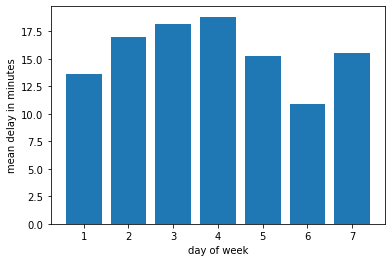

In [13]:
delays = delays_per_day(flight_data,airport_map)
plt.bar(x=range(1,8),height=delays)
plt.xlabel('day of week')
plt.ylabel('mean delay in minutes')
plt.show()